In [19]:
import pandas as pd
import pydicom , os, cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# About Dataset
We have 2 folder, one containg train data and other test data
- dicom train image
- dicom test image

Inside each folder we have DICOM (Digital Imaging and Communications in Medicine) formatted files, for some reason every single image is embedded in two more folders. 
Also we have a csv file which provides mask encodings for each image

In [2]:
train_fns = sorted(glob('/Users/hendrichscullen/Desktop/Project/EDA_Pneum_Dataset/src_data/siim/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('/Users/hendrichscullen/Desktop/Project/EDA_Pneum_Dataset/src_data/siim/dicom-images-test/_/_/*.dcm'))

print(f'Number train image in folder: {len(train_fns)}')
print(f'Number test image in folder: {len(test_fns)}')

df = pd.read_csv('/Users/hendrichscullen/Desktop/Project/EDA_Pneum_Dataset/src_data/siim/train-rle.csv')
print(df.shape)

print(f'Total no off unique images in csv files: {df["ImageId"].nunique()}')
print(f'Image with duplicate Enncodes Pixels, Multiple annotations: {df[df.duplicated(subset=["ImageId"])].shape[0]}')

df.head()

Number train image in folder: 12089
Number test image in folder: 3205
(12954, 2)
Total no off unique images in csv files: 12047
Image with duplicate Enncodes Pixels, Multiple annotations: 907


ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...   
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.11028.15178752...   
3  1.2.276.0.7230010.3.1.4.8323329.10366.15178752...   
4  1.2.276.0.7230010.3.1.4.8323329.10016.15178752...   

                                       EncodedPixels  
0                                                 -1  
1  557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...  
2                                                 -1  
3  514175 10 1008 29 994 30 993 32 991 33 990 34 ...  
4  592184 33 976 58 956 73 941 88 926 102 917 109...

In [3]:
# code from https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
def show_info(dataset):
    print("Filename......:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixels(dataset, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

Filename......: /Users/hendrichscullen/Desktop/Project/EDA_Pneum_Dataset/src_data/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026/1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 17d405a3-a0d2-4901-b33a-63906aa48d9f, 
Patient id..........: 17d405a3-a0d2-4901-b33a-63906aa48d9f
Patient's Age.......: 38
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 130476 bytes
Pixel spacing....: [0.168, 0.168]


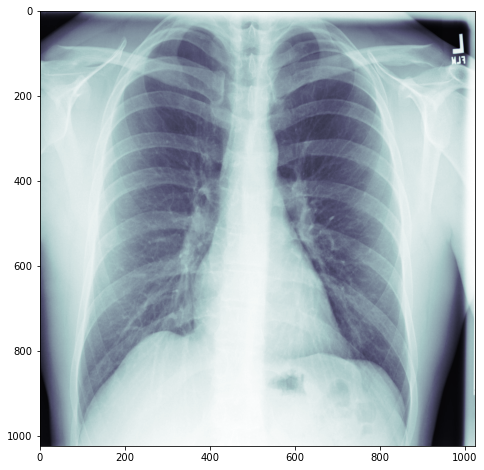

In [7]:
file_path = train_fns[0]
data = pydicom.dcmread(file_path)
show_info(data)
plot_pixels(data)

In [5]:
missing = 0
multiple = 0
patients_data = []
for k,paths in enumerate(train_fns):
    patient = {}
    img_id = paths.split('/')[-1]
    data = pydicom.dcmread(paths)
    try:
        tmp = df[df['ImageId'] == '.'.join(img_id.split('.')[:-1])]
        
        if tmp.shape[0] > 1: 
            multiple += 1
        rle = tmp[' EncodedPixels'].values
        if rle[0] == '-1':
            pixels = rle[0]
        else:    
            pixels = [i for i in rle]
        
        patient["UID"] = data.SOPInstanceUID
        patient['EncodedPixels'] = pixels
        patient["Age"] = data.PatientAge
        patient["Sex"] = data.PatientSex
        patient["Modality"] = data.Modality
        patient["BodyPart"] = data.BodyPartExamined
        patient["ViewPosition"] = data.ViewPosition
        patient["filepath"] = paths
        patients_data.append(patient)
    except:
        missing += 1

print(f'We have {missing} dicom in folder which is not present in csv')
print(f'There are {multiple} images with more than 1 annotation')
df_patients = pd.DataFrame(patients_data, columns=["UID", "EncodedPixels", "Age", 
                            "Sex", "Modality", "BodyPart", "ViewPosition", "filepath"])

df_patients['Pneumothorax'] = df_patients['EncodedPixels'].apply(lambda x:0 if x == '-1' else 1)
df_patients['Pneumothorax'] = df_patients['Pneumothorax'].astype('int')
print("images with labels: ", df_patients.shape[0])
df_patients.head() 

We have 42 dicom in folder which is not present in csv
There are 624 images with more than 1 annotation
images with labels:  12047


UID EncodedPixels Age Sex  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...            -1  38   M   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...            -1  10   F   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...            -1  50   F   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...            -1  68   F   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...            -1  65   M   

  Modality BodyPart ViewPosition  \
0       CR    CHEST           PA   
1       CR    CHEST           AP   
2       CR    CHEST           AP   
3       CR    CHEST           AP   
4       CR    CHEST           AP   

                                            filepath  Pneumothorax  
0  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0  
1  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0  
2  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0  
3  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0  
4  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0

In [8]:
df_patients['Pneumothorax'].value_counts()

0    9378
1    2669
Name: Pneumothorax, dtype: int64

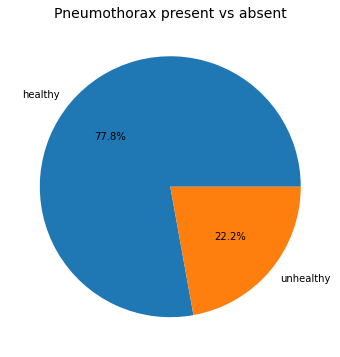

In [9]:
tmp = df_patients['Pneumothorax'].value_counts()
df_patients['Pneumothorax'] = df_patients['Pneumothorax'].astype('int')
fig, ax = plt.subplots(figsize=[10,6])
ax.pie(tmp,labels =['healthy','unhealthy'],autopct="%.1f%%");
plt.title("Pneumothorax present vs absent", fontsize=14);

In [10]:
def plot_dual(col):
    """
    plot pie chart and bar graph
    """
    tmp = df_patients[['Pneumothorax',col]]
    tmp = tmp.groupby(by=col).mean().reset_index()
    fig, axes = plt.subplots(1,2,figsize=(15,8))
    
    tmp2 = df_patients[col].value_counts()
    axes[0].pie(tmp2,labels = tmp2.index ,
            autopct="%.2f%%",pctdistance=0.5);
    axes[0].set_title("Total count")
    sns.barplot(x=tmp[col],y=tmp['Pneumothorax'],ax=axes[1])
    axes[1].set_title(f"Pneumothorax among different {col}")
    plt.show()

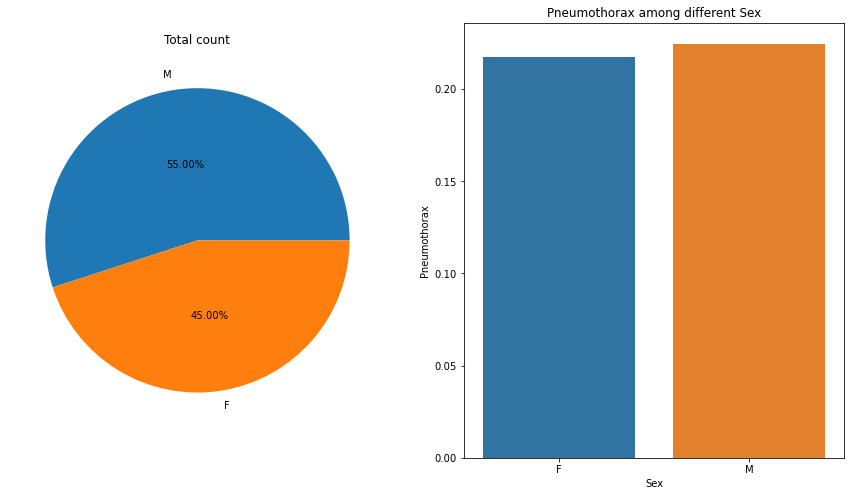

In [11]:
plot_dual('Sex')

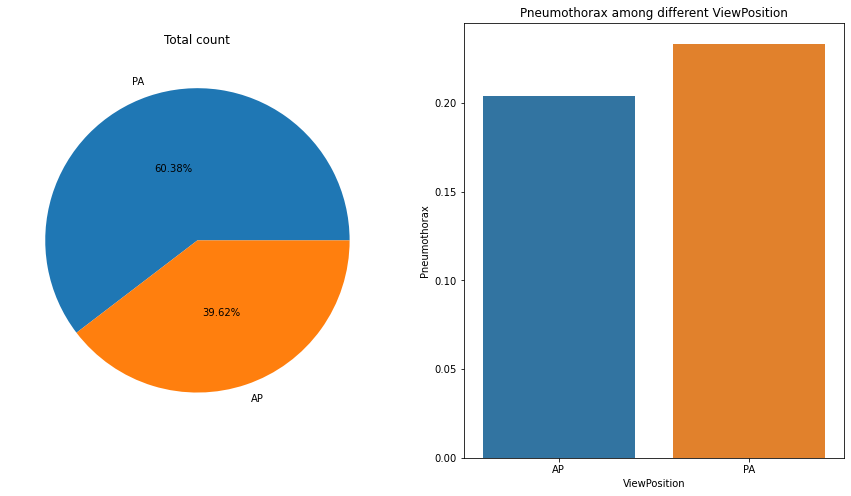

In [12]:
plot_dual('ViewPosition')

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


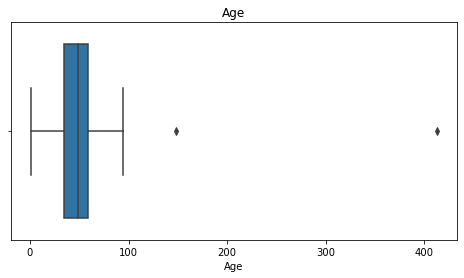

In [13]:
df_patients['Age'] = df_patients['Age'].astype('int') 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,4))
sns.boxplot(df_patients['Age'])
axes.title.set_text(f'Age')
plt.show()

In [14]:
df_patients[df_patients['Age'] > 100]

UID EncodedPixels  Age  \
1204  1.2.276.0.7230010.3.1.4.8323329.11106.15178752...            -1  413   
9624  1.2.276.0.7230010.3.1.4.8323329.4830.151787518...            -1  148   

     Sex Modality BodyPart ViewPosition  \
1204   F       CR    CHEST           AP   
9624   M       CR    CHEST           PA   

                                               filepath  Pneumothorax  
1204  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0  
9624  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0

In [15]:
df_patients = df_patients.drop(df_patients[df_patients['Age'] > 100].index)
print(df_patients.shape)

(12045, 9)


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

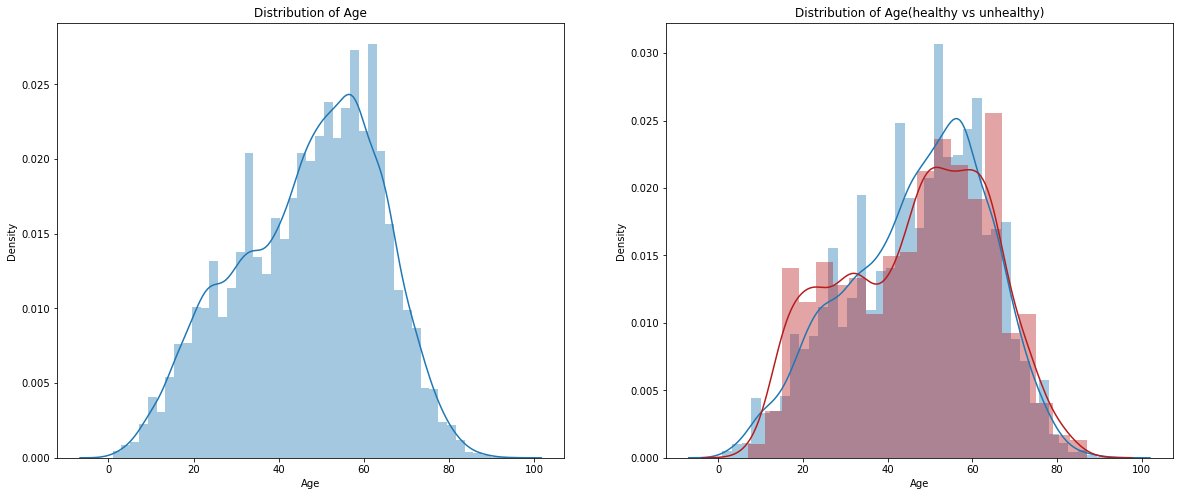

In [16]:
non_healthy = df_patients[df_patients['Pneumothorax'] == 1] 
healthy = df_patients[df_patients['Pneumothorax'] == 0]

df_patients['Age'] = df_patients['Age'].astype('int') 
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
sns.distplot(df_patients['Age'],ax=axes[0])
axes[0].title.set_text('Distribution of Age')
sns.distplot(healthy['Age'],ax=axes[1])
sns.distplot(non_healthy['Age'],ax=axes[1],color='#B71C1C')
axes[1].title.set_text('Distribution of Age(healthy vs unhealthy)')
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

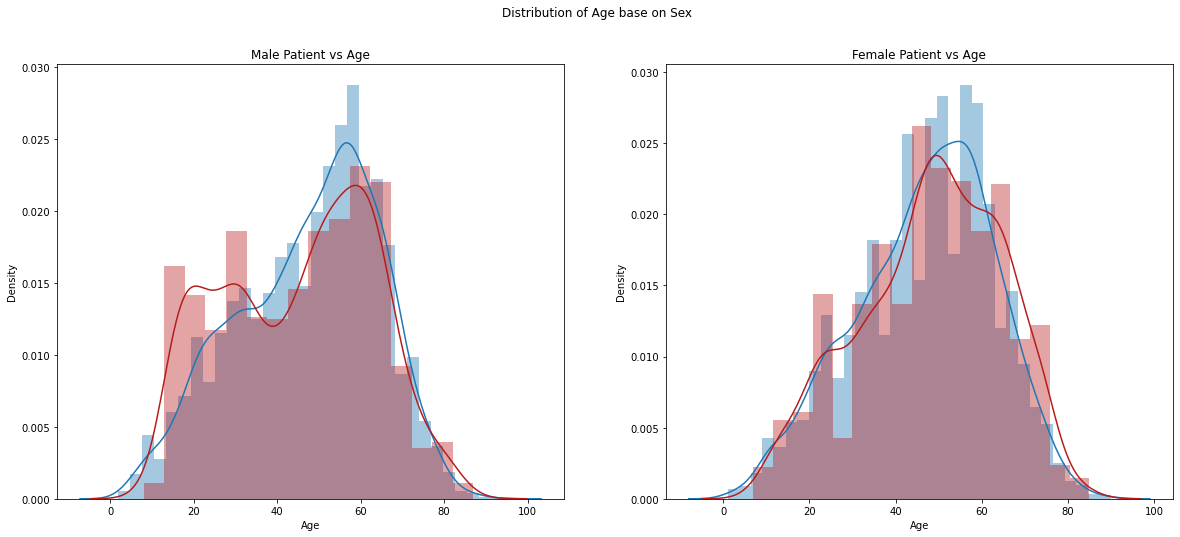

In [17]:
tmp_male = df_patients[df_patients['Sex'] == 'M'] 
tmp_female = df_patients[df_patients['Sex'] == 'F'] 

non_healthy_M = tmp_male[tmp_male['Pneumothorax'] == 1] 
healthy_M = tmp_male[tmp_male['Pneumothorax'] == 0]
non_healthy_F = tmp_female[tmp_female['Pneumothorax'] == 1] 
healthy_F = tmp_female[tmp_female['Pneumothorax'] == 0]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
sns.distplot(healthy_M['Age'],ax=axes[0])
sns.distplot(non_healthy_M['Age'],ax=axes[0],color='#B71C1C')
axes[0].set_title('Male Patient vs Age')
sns.distplot(healthy_F['Age'],ax=axes[1])
sns.distplot(non_healthy_F['Age'],ax=axes[1],color='#B71C1C')
axes[1].set_title('Female Patient vs Age')
plt.suptitle(f'Distribution of Age base on Sex')
plt.show()

In [20]:
# check the train images
means = []
for fn in tqdm(train_fns):
    img = pydicom.read_file(fn).pixel_array
    means.append(img.mean())
print("Train mean: ", np.mean(means))

# check the test images
means = []
for fn in tqdm(test_fns):
    img = pydicom.read_file(fn).pixel_array
    means.append(img.mean())
print("Test mean: ", np.mean(means))

100%|██████████| 12089/12089 [02:03<00:00, 97.91it/s] 


Train mean:  125.03749605447524


100%|██████████| 3205/3205 [00:34<00:00, 92.13it/s]

Test mean:  124.62664661734784


In [22]:
# Here out RLE encoding is little bit different
def rle2mask(rles, width, height):
    """
    
    rle encoding if images
    input: rles(list of rle), width and height of image
    returns: mask of shape (width,height)
    """
    
    mask= np.zeros(width* height)
    for rle in rles:
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]

        current_position = 0
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 255
            current_position += lengths[index]

    return mask.reshape(width, height).T

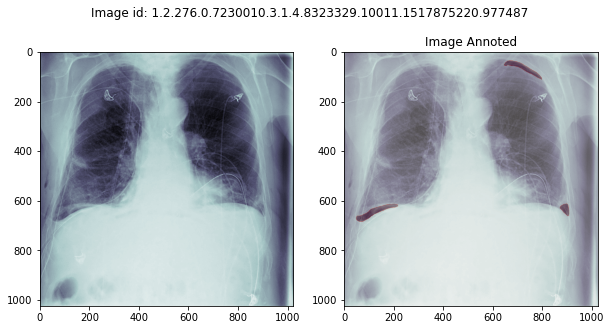

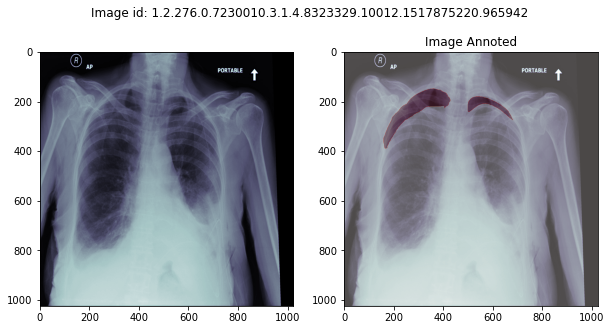

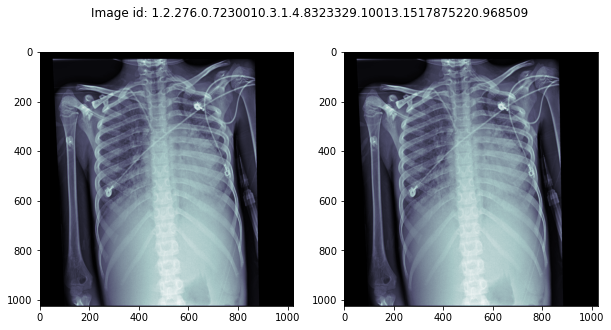

In [23]:
for file in train_fns[13:16]:
    data = pydicom.dcmread(file)
    image = data.pixel_array
    id_ = '.'.join(file.split('/')[-1].split('.')[:-1])
    rle = df[df['ImageId'] == str(id_)][' EncodedPixels'].values
    if rle[0] == '-1':
        fig,axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(image,cmap='bone')
        axes[1].imshow(image,cmap='bone')
        plt.suptitle(f'Image id: {id_}')
        plt.show()
    else:
        fig,axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(image,cmap='bone')
        mask = rle2mask(rle,image.shape[0],image.shape[1])
        axes[1].imshow(image,cmap='bone')
        axes[1].imshow(mask,alpha=0.3,cmap='Reds')
        axes[1].set_title('Image Annoted')
        plt.suptitle(f'Image id: {id_}')
        plt.show()

In [24]:
def bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    return rmin, cmin, rmax, cmax #ymin,xmin,ymax,cmax


def plot_imgs(n,df):
    for i in range(n):
        idx = np.random.randint(0,df.shape[0])
        tmp = df.iloc[idx]
        # path of file
        path = tmp['filepath']
        encoding = tmp['EncodedPixels']
        image = pydicom.dcmread(path).pixel_array
        fig, axes = plt.subplots(1,4, figsize=(20,15))
        axes[0].imshow(image, cmap='bone')
        axes[0].set_title('Image')
        mask = rle2mask(encoding,image.shape[0],image.shape[1])
        axes[1].imshow(mask,cmap='gray')
        axes[1].set_title('Mask')
        axes[2].imshow(image,cmap='bone')
        axes[2].imshow(mask,alpha=0.3,cmap='Reds')
        axes[2].set_title('Image + mask')
        rmin, cmin, rmax, cmax = bounding_box(mask)
        image_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        cv2.rectangle(image_rgb, (cmin,rmin),(cmax,rmax), (255,255,0), 5)
        axes[3].imshow(image_rgb)
        axes[3].imshow(mask,alpha=0.3,cmap='Reds')
        axes[3].set_title('Image Box Annoted')
        plt.show()

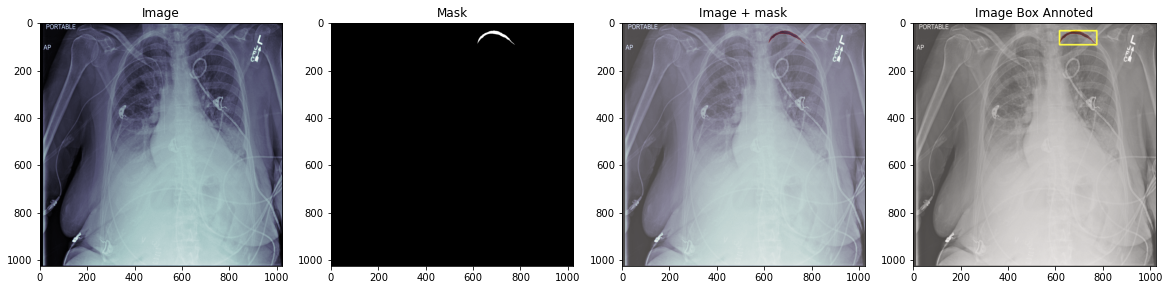

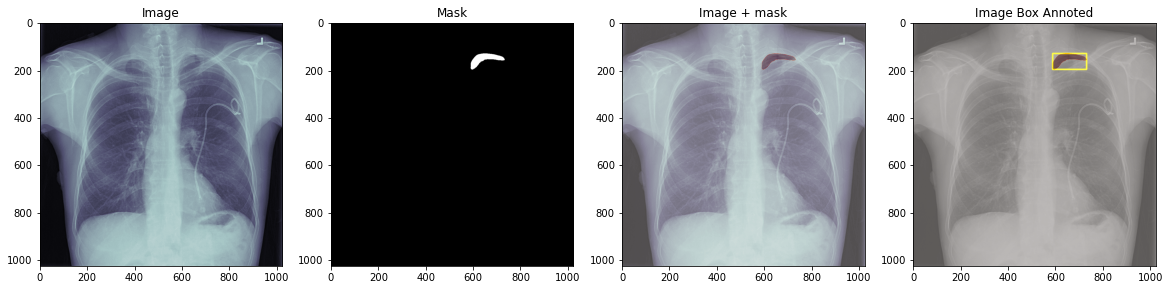

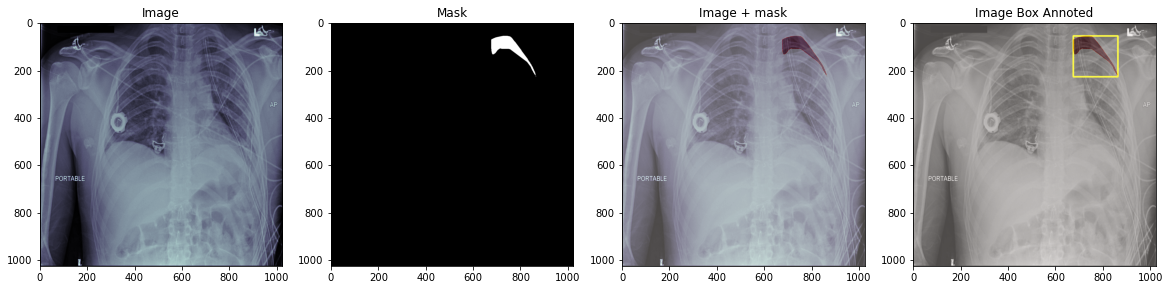

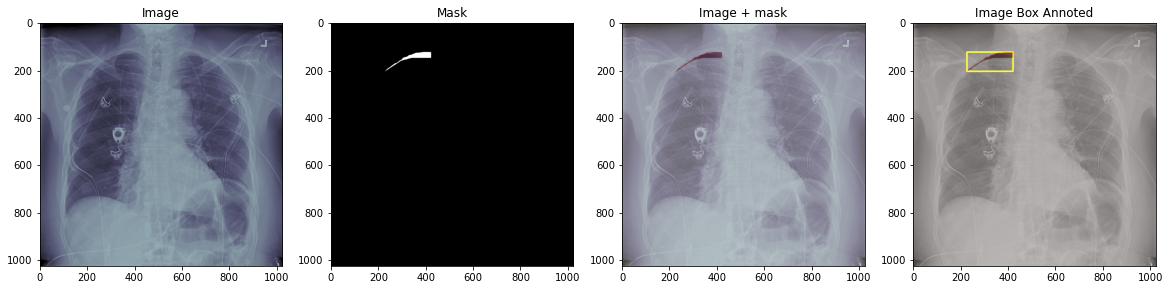

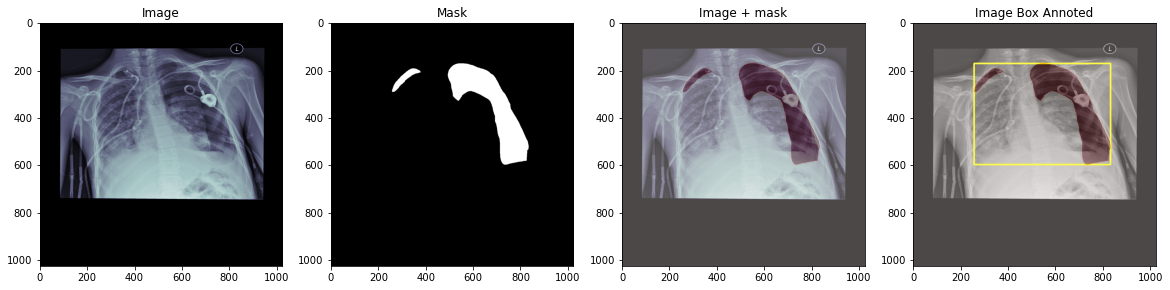

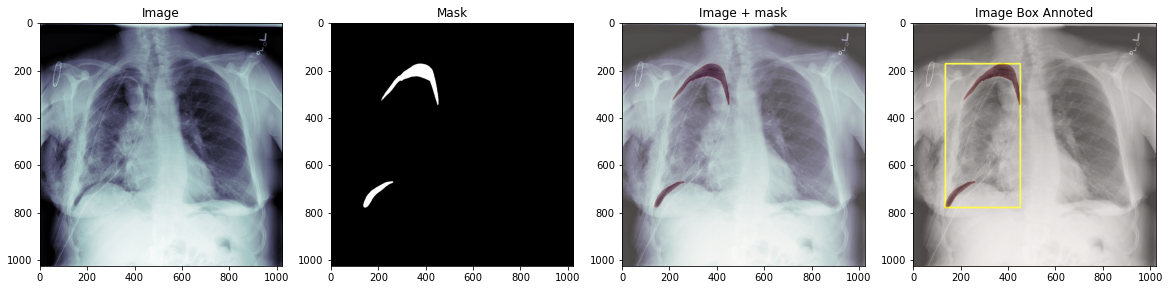

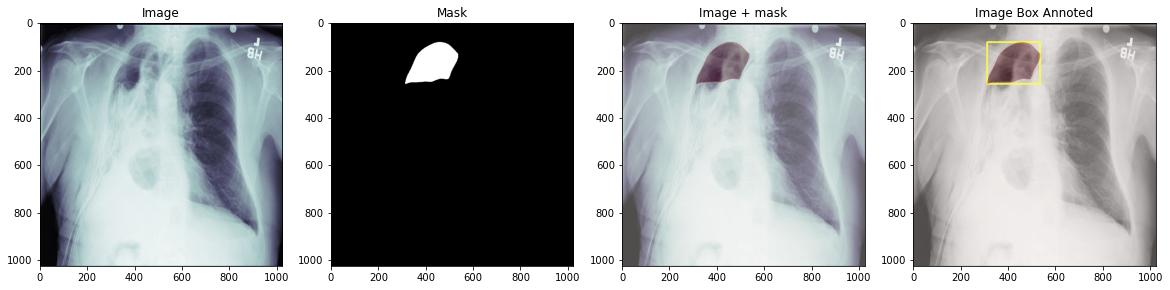

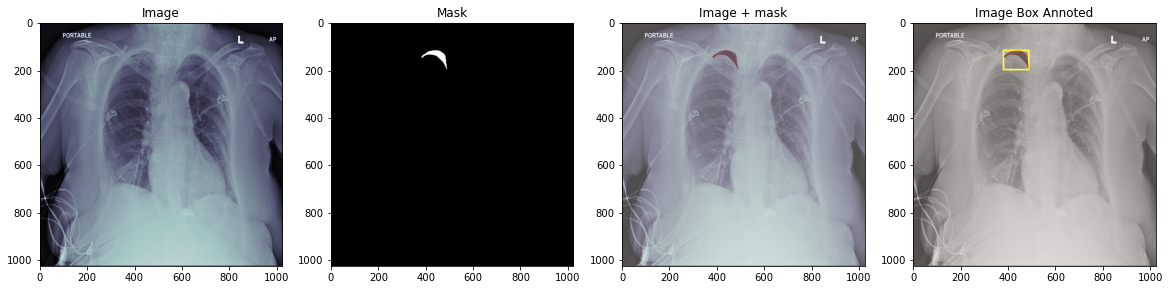

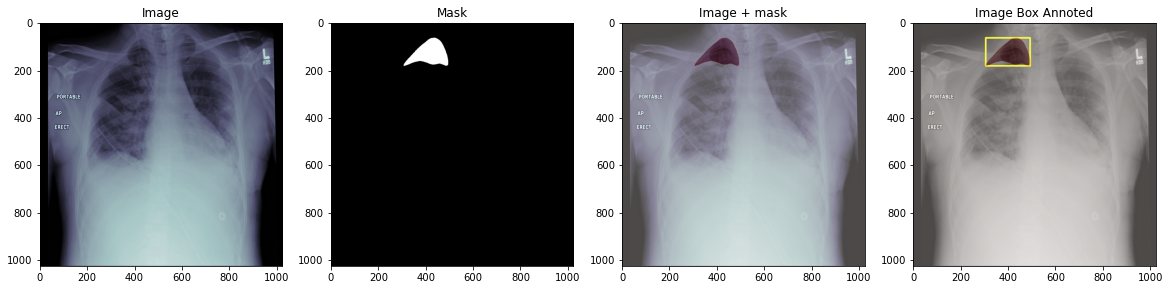

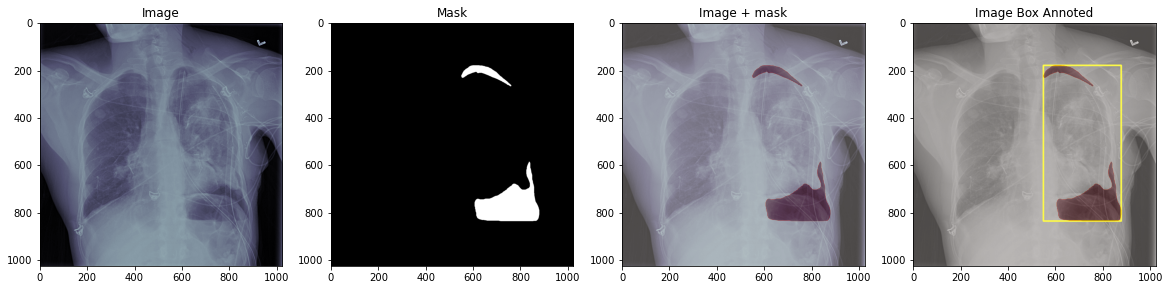

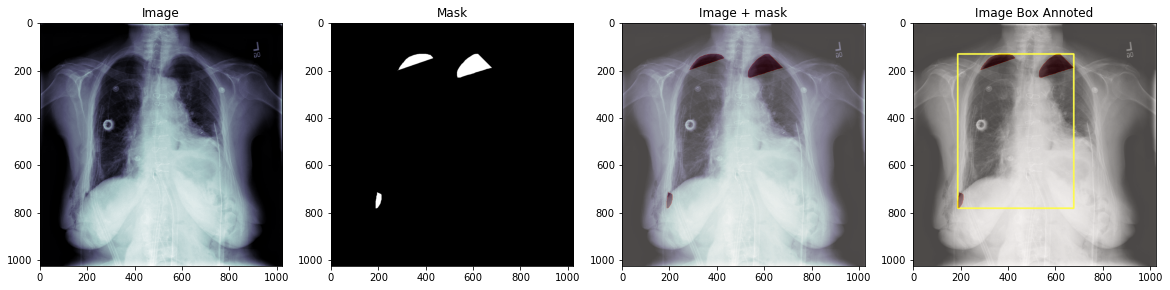

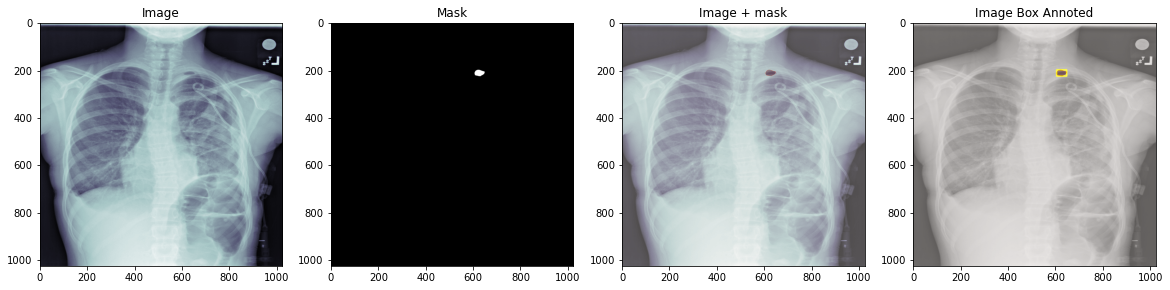

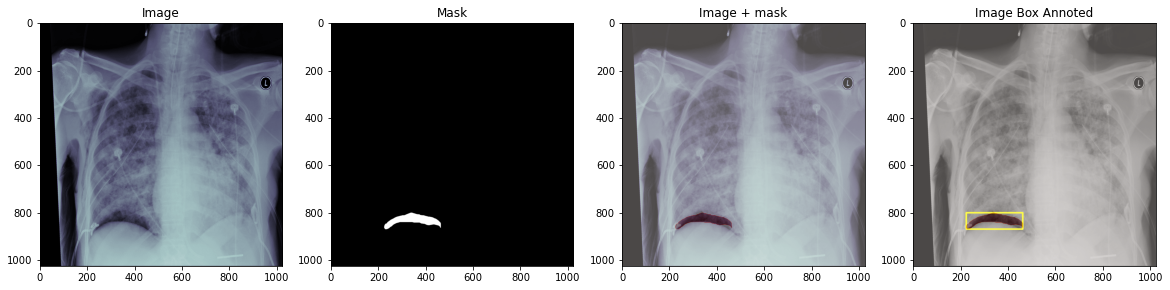

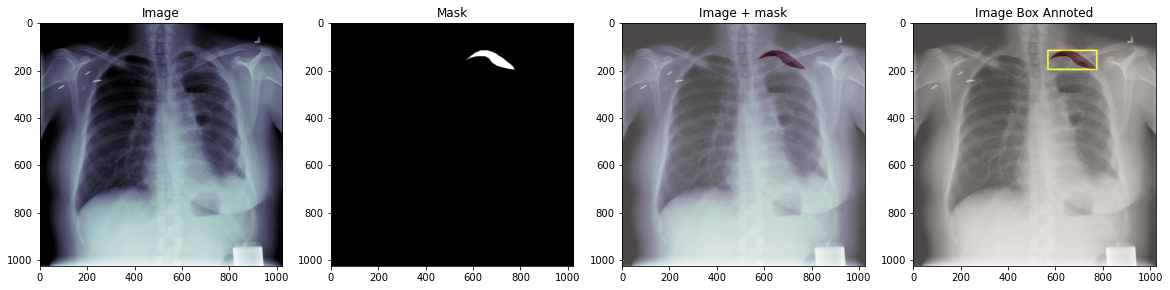

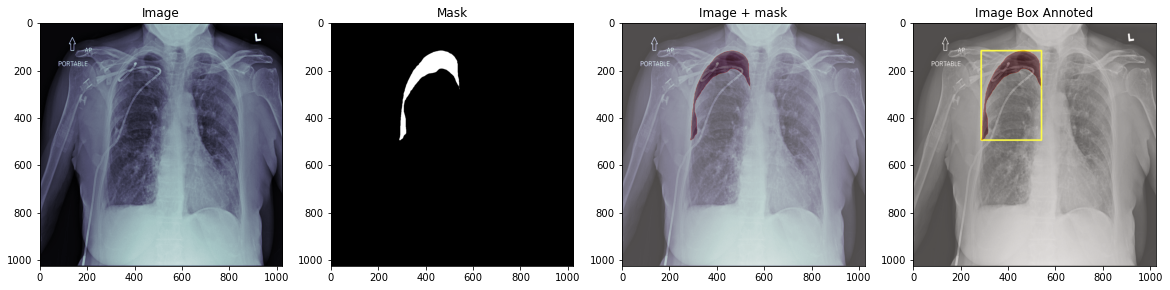

In [25]:
tmp = df_patients[df_patients['Pneumothorax'] == 1].reset_index(drop=True)
plot_imgs(15,tmp)

In [26]:
df_patients.to_csv('processed.csv',index=False)

dff = pd.read_csv('processed.csv')
dff.head()

UID EncodedPixels  Age Sex  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...            -1   38   M   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...            -1   10   F   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...            -1   50   F   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...            -1   68   F   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...            -1   65   M   

  Modality BodyPart ViewPosition  \
0       CR    CHEST           PA   
1       CR    CHEST           AP   
2       CR    CHEST           AP   
3       CR    CHEST           AP   
4       CR    CHEST           AP   

                                            filepath  Pneumothorax  
0  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0  
1  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0  
2  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0  
3  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0  
4  /Users/hendrichscullen/Desktop/Project/EDA_Pne...             0